# To Analyze how travelers expressed their feelings on Twitter.
- Only demonstrating a part of a project not the full implementation.


# Import modules and create spark session

In [1]:
# create spark context 
from pyspark import SparkContext
sc = SparkContext(master = "local")
                  
# initialize the Spark Session
from pyspark.sql import SparkSession

#create Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sentiment Analysis in pySpark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Reading Data file into Spark DataFrame

In [2]:
# --- reading data via Spark
df = spark.read.csv("./*.csv", inferSchema = True, header = True, sep=",")
df.printSchema()


root
 |-- tweet_id: string (nullable = true)
 |-- airline_sentiment: string (nullable = true)
 |-- airline_sentiment_confidence: string (nullable = true)
 |-- negativereason: string (nullable = true)
 |-- negativereason_confidence: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- airline_sentiment_gold: string (nullable = true)
 |-- name: string (nullable = true)
 |-- negativereason_gold: string (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- tweet_coord: string (nullable = true)
 |-- tweet_created: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- user_timezone: string (nullable = true)



In [3]:
df = df.na.drop(subset=["airline_sentiment","airline","text"])

In [4]:
from pyspark.sql.functions import col, expr, when
df = df.withColumn('airline_sentiment', when(col('airline_sentiment')=='positive', 2)
                .when(col('airline_sentiment')=='negative',0)
              .otherwise(1))


## Select the related data

In [5]:
# --- select only "text" and "airline_sentiment" column, 
# --- and cast "airline_sentiment" column data into integer
data = df.select(col("airline_sentiment").cast("Int").alias("label"),"text")
data.show(truncate = False,n=5)

+-----+----------------------------------------------------------------------------------------------------------------------------------+
|label|text                                                                                                                              |
+-----+----------------------------------------------------------------------------------------------------------------------------------+
|1    |@VirginAmerica What @dhepburn said.                                                                                               |
|2    |@VirginAmerica plus you've added commercials to the experience... tacky.                                                          |
|1    |@VirginAmerica I didn't today... Must mean I need to take another trip!                                                           |
|0    |"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"|
|0    |@VirginAmerica and i

In [6]:
data.printSchema()

root
 |-- label: integer (nullable = false)
 |-- text: string (nullable = true)



### Divided the data into training and testing

In [7]:
# #divide data, 70% for training, 30% for testing
# dividedData = data.randomSplit([0.7, 0.3]) 
# trainingData = dividedData[0] #index 0 = data training
# testingData = dividedData[1] #index 1 = data testing

In [8]:
# trainingData.write.csv('train.csv')
# testingData.write.csv('test.csv')

# Importing MLlib: RDD-based API and all required lib.

In [9]:
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.feature import ChiSqSelector

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import os, tempfile
import csv
import string
import random

## Data Cleaning

In [10]:
# --- function to remove stop words
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

# --- function to handle numbers, single characters URL's and @Username
# --- Cleaning data

def clean(filename):
    text=open(filename, encoding='ISO-8859-1')
    file_reader = csv.reader(text)
    clean_final=[]
    c=0
    stop=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']
    shuffle=[]
    tweet_list=[]
    for row in file_reader:
        temp_t=row[1]
        ts=temp_t.split(" ")
        for w in range(1,len(ts)):
            ts[w]=ts[w].lower()
            if (ts[w]!='' and ts[w][0]=='@'):
                ts[w]='AT_USER'
            if (ts[w]!='' and len(ts[w])>4  and ts[w][0]=='w' and ts[w][1]=='w' and ts[w][2]=='w' and ts[w][3]=='.'):
                ts[w]='URL'
            if (ts[w]!='' and len(ts[w])>7  and ts[w][0]=='h' and ts[w][1]=='t' and ts[w][2]=='t' and ts[w][3]=='p' and
                ts[w][4]==':' and ts[w][5]=='/' and ts[w][6]=='/'):
                ts[w]='URL'
            if (ts[w]!='' and len(ts[w])>8  and ts[w][0]=='h' and ts[w][1]=='t' and ts[w][2]=='t' and ts[w][3]=='p' and
                ts[w][4]=='s' and ts[w][5]==':' and ts[w][6]=='/' and ts[w][7]=='/'):
                ts[w]='URL'
            for i in range(0,len(ts[w])):
                flag=0
                if len(ts[w])>i+2 and ts[w][i]==ts[w][i+1] and ts[w][i]==ts[w][i+2]:
                    for j in range(i+2,len(ts[w])):
                        if ts[w][i]==ts[w][j]:
                            flag=1
                            if len(ts[w])>j+1 and ts[w][i]!=ts[w][j+1]:
                                break
                        if j==(len(ts[w]))-1 and ts[w][i]==ts[w][j]:
                            flag=1
                            break
                    if flag==1:
                        ts[w]=ts[w].replace(ts[w][i:j+1],ts[w][i])
            if (ts[w]!='' and ts[w][0].isdigit()):
                ts[w]=''
        for i in range(0,len(stop)):
            if stop[i] in ts:
                ts = remove_values_from_list(ts, stop[i])
        cleaned_list=[word.strip(string.punctuation) for word in ts]
        while '' in cleaned_list:
            cleaned_list.remove('')
        clean_final.append(cleaned_list)
        shuffle.append([row[0],cleaned_list])
        tweet_list.append(row[1])
    return (shuffle,tweet_list)

### Processed data for training 

In [11]:
# Replace the path of train.csv in the "_____"    
train_shuffle,train_tweet_list=clean("train.csv/part-00000-0c2be565-64f3-483f-a8fd-2d14ac0f34df-c000.csv")

### Processed data for testing 

In [12]:
#test on test.csv(reading test.csv and classifying)
# Replace the path of test.csv in the "_____"
test_shuffle,test_tweet_list=clean("test.csv/part-00000-c88a2743-382f-42bf-a7fd-45a1a534c8a0-c000.csv")

## TF-IDF functions 

In [13]:
#Compute TF
def CompTF(tshuffle_rdd):
    t_rdd=sc.parallelize([row[1] for row in tshuffle_rdd.collect()])
    hashingTF = HashingTF(50000)
    tf = hashingTF.transform(t_rdd)
    return tf
def CompTF_withNumFeatures(tshuffle_rdd):
    t_rdd=sc.parallelize([row[1] for row in tshuffle_rdd.collect()])
    hashingTF = HashingTF(1500)
    tf = hashingTF.transform(t_rdd)
    return tf
#Compute IDF
def CompIDF(tf):
    tf.cache()
    idf = IDF().fit(tf)
    return idf
#Compute TFIDF
def CompTFIDF(tf,idf):
    tfidf = idf.transform(tf)
    return tfidf


In [14]:
#Feature Extraction
def Convert_to_LabeledPoint(labels,features):
    training = labels.zip(features).map(lambda x: LabeledPoint(x[0], x[1]))
    return training

## Training Algorithms 

In [15]:
# --- Naive Bayes
#Training - NB
def NB_train(training):
    model = NaiveBayes.train(training)
    return model

# --- Logistic Regression
#Training - LG
def LG_train(training):
    model = LogisticRegressionWithLBFGS.train(training,numClasses=3)
    return model


# --- Decision Trees
#Training - DT
def DT_train(training):
    model = DecisionTree.trainClassifier(training, numClasses=3, categoricalFeaturesInfo={},
                                        impurity='gini', maxDepth=5, maxBins=32)
    return model

In [16]:
#Testing
def test(model,labels,features):
    labels_and_preds = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "predicted": float(x[1])})
    acc=100.0*((labels_and_preds.filter(lambda x:x["actual"]==x["predicted"]).count()) / (labels.count()))
    return acc

#Testing with pred prob
def test_wpp(model,labels,features):
    labels_and_probs = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "probs": float(x[1])})
    return labels_and_probs
    
#Final Test
def test_final(model,labels,features):
    labels_and_preds = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "predicted": float(x[1])})
    acc=100.0*((labels_and_preds.filter(lambda x:x["actual"]==x["predicted"]).count()) / (labels.count()))
    return (labels_and_preds,acc)


In [17]:
# tpr and fpr
def tf(labels_and_preds):
    true_pos = (labels_and_preds.filter(lambda x:x["predicted"]==1 and x["actual"]==1).count())
    true_neg = (labels_and_preds.filter(lambda x:x["predicted"]==0 and x["actual"]==0).count())
    false_pos = (labels_and_preds.filter(lambda x:x["predicted"]==1 and x["actual"]==0).count())
    false_neg = (labels_and_preds.filter(lambda x:x["predicted"]==0 and x["actual"]==1).count())

    tpr=(true_pos)/(true_pos+false_neg)
    fpr=(false_pos)/(false_pos+true_neg)
    return (tpr,fpr)

## Spliting the training data for Cross-Validation

In [18]:
random.shuffle(train_shuffle)
tshuff_rdd_train=sc.parallelize(train_shuffle)
p=tshuff_rdd_train.randomSplit(weights=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], seed=1)


## Applying Logistic Regression 

### 1. Training

In [19]:
%%time
# Accuracy of Training data using train.csv itself using LG
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)
training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)

print(training.first())

model_train_LG=LG_train(training)
accuracy=test(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
#accuracy_LG=test(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
print ("\n TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using Logistic Regression is",accuracy,"%")
print ("\n")

(0.0,(50000,[979,1709,9485,13294,13785,14325,19611,20311,24093,27012,33856,39589,41115,44824,46593],[1.827842758390725,5.051629581465553,6.923431758367145,4.005661026282866,3.1857621400837766,7.8397224902413,8.12740456269308,3.942813122623202,4.991910346763931,3.841521788572101,3.7085639548964826,3.41487585838449,5.13167228913909,4.005661026282866,4.114029063004647]))

 TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using Logistic Regression is 99.20252042926062 %


CPU times: user 365 ms, sys: 62 ms, total: 427 ms
Wall time: 19.2 s


### 2. Validation using K Fold Cross Validation

In [20]:
%%time
# KFold Logistic Regression
print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")
tot_LG_kfold=0
LG_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in train_tempRDD.collect()]),tfidf_train)
    model_train=LG_train(training)
    tf_test=CompTF(test_RDD)
    tfidf_test=CompTFIDF(tf_test,idf_train)
    accuracy_LG=test(model_train,sc.parallelize([row[0] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for LG is",accuracy_LG,"%")
    tot_LG_kfold=tot_LG_kfold+accuracy
    LG_kfold_set.append(accuracy)
avg_LG_kfold=tot_LG_kfold/len(p)
LG_kfold_best=max(LG_kfold_set)
print ("\n")
print ("The average accuracy for LG after 10-fold cross validation is",avg_LG_kfold,"%")
print ("\n")
print ("The highest accuracy for LG after 10-fold cross validation is",LG_kfold_best,"%")
print ("\n")

10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for LG is 65.92065106815869 %
The accuracy for number 2 kth partition test for 10-fold cross validation for LG is 68.75612144955926 %
The accuracy for number 3 kth partition test for 10-fold cross validation for LG is 68.3223992502343 %
The accuracy for number 4 kth partition test for 10-fold cross validation for LG is 68.40607210626186 %
The accuracy for number 5 kth partition test for 10-fold cross validation for LG is 69.17599186164801 %
The accuracy for number 6 kth partition test for 10-fold cross validation for LG is 68.35820895522387 %
The accuracy for number 7 kth partition test for 10-fold cross validation for LG is 70.03089598352214 %
The accuracy for number 8 kth partition test for 10-fold cross validation for LG is 72.37093690248567 %
The accuracy for number 9 kth partition test for 10-fold cross validation for LG is 68.03519061583577 %
The accuracy for number

### 3. Testing the model on the test dataset.

In [21]:
%%time
tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(tshuff_rdd_test)
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)

labels_and_preds_LG,accu_LG = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)

print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for LG on testing data is",accu_LG,"%")
print ("\n")


TEST ACCURACY:-

The accuracy of prediction for LG on testing data is 68.47996418177748 %


CPU times: user 236 ms, sys: 45.3 ms, total: 282 ms
Wall time: 1.35 s


### 4. Ploting different accuracies 

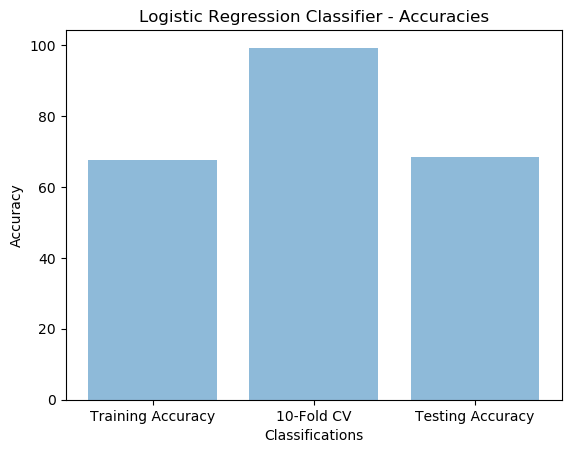

In [22]:
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_LG,avg_LG_kfold,accu_LG]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Classifier - Accuracies') 
plt.show()

### 5. Model Summary - Confussion metrics

In [23]:
metrics = MulticlassMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))
# Model summary 
print("\nSummary Stats_LG\n")
labels = (sc.parallelize([row[0] for row in tshuff_rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_LG = %s" % (label, metrics.precision(label)))
    print("Class %s recall_LG = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_NB = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))
# Model Weighted Stats 
print("\n\nAvg/Weighted recall_LG = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_LG = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_LG = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_LG=")
print(cm)
print("\n\n")


Summary Stats_LG

Class 0 precision_LG = 0.7994942196531792
Class 0 recall_LG = 0.7946140035906643
Class 0 F1 Measure_NB = 0.7970466414550693
Class 1 precision_LG = 0.4359504132231405
Class 1 recall_LG = 0.4494142705005325
Class 1 F1 Measure_NB = 0.44257996853696907
Class 2 precision_LG = 0.5800273597811217
Class 2 recall_LG = 0.5706594885598923
Class 2 F1 Measure_NB = 0.5753052917232022


Avg/Weighted recall_LG = 0.6847996418177748
Avg/Weighted precision_LG = 0.6865702189541094
Avg/Weighted F(1) Score_LG = 0.6856524107138843

Confusion matrix_LG=
[[2213.  398.  174.]
 [ 384.  422.  133.]
 [ 171.  148.  424.]]





### 6. ROC Curve and AUC

Area under ROC_Logistic_Regression = 0.7454008756780528


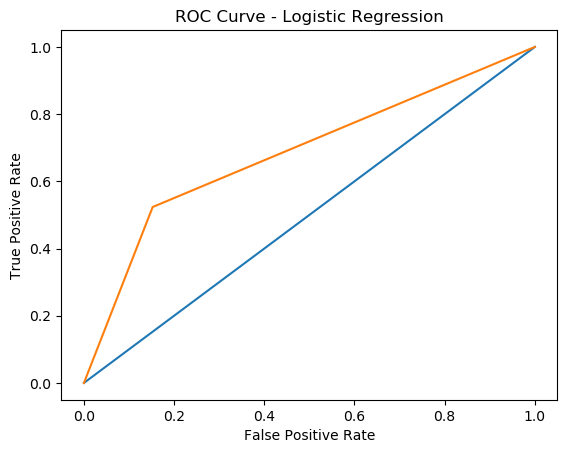

In [24]:
model_train_LG.setThreshold(0.25)
labels_and_preds_LG2,accu_LG2 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
model_train_LG.setThreshold(0.75)
labels_and_preds_LG3,accu_LG3 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
model_train_LG.setThreshold(0.1)
labels_and_preds_LG4,accu_LG4 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
model_train_LG.setThreshold(0.9)
labels_and_preds_LG5,accu_LG5 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)

tpr,fpr=tf(labels_and_preds_LG) 
tpr2,fpr2=tf(labels_and_preds_LG2) 
tpr3,fpr3=tf(labels_and_preds_LG3)
tpr4,fpr4=tf(labels_and_preds_LG4) 
tpr5,fpr5=tf(labels_and_preds_LG5) 

x = [0,fpr5,fpr3,fpr,fpr2,fpr4,1]
y = [0,tpr5,tpr3,tpr,tpr2,tpr4,1]

# This is the ROC curve
x1=[0,1]
y1=[0,1]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.plot(x1,y1)
plt.plot(x,y)

metrics2 = BinaryClassificationMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))
model_train_LG.clearThreshold()
labels_and_probs_LG=test_wpp(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
metrics = MulticlassMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))
# Area under ROC curve
print("Area under ROC_Logistic_Regression = %s" % metrics2.areaUnderROC)
plt.show()